In [38]:
import folium

In [39]:
m = folium.Map(location=[28.116667, -17.216667])
m
#m.save("map_folium.html")

In [40]:
#m = folium.Map(location=[28.116667, -17.216667], tiles="https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}", zoom_start=10,attr="Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri")
#m = folium.Map(location=[28.116667, -17.216667], tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", zoom_start=13,attr="Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri")
m = folium.Map(location=[28.116667, -17.216667], tiles="https://tile.opentopomap.org/{z}/{x}/{y}.png", zoom_start=11,attr="OpenTopoMap (CC-BY-SA)")

m.add_child(folium.LatLngPopup())

m

In [41]:
m = folium.Map(location=[28.116667, -17.216667], tiles="https://tiles.emodnet-bathymetry.eu/2020/baselayer/web_mercator/{z}/{x}/{y}.png", zoom_start=11,attr="Emodnet bathymetry")
m

In [42]:
map_geo = folium.Map(location=[28.116667, -17.216667])
folium.raster_layers.WmsTileLayer(url = 'https://ows.emodnet-bathymetry.eu/wms?VERSION%3D1.3.0',
                                  layers = 'emodnet:contours',
                                  transparent = True, 
                                  control = True,
                                  fmt="image/png",
                                  name = 'bathymetry',
                                  overlay = True,
                                  show = True,
                                  ).add_to(map_geo)
folium.LayerControl().add_to(map_geo)
map_geo

In [43]:
import pandas as pd
import folium
from folium.plugins import BeautifyIcon

variables = ['Long', 'Lat', 'Year', 'Name', 'Shore distance','Depth','Date','WKT']

df_gm = pd.read_csv('data/gm.csv', sep=';')
df_gm.columns = variables
df_sf = pd.read_csv('data/sf.csv', sep=';')
df_sf.columns = variables
df_tt = pd.read_csv('data/tt.csv', sep=';')
df_tt.columns = variables

frames = [df_gm, df_sf, df_tt]

df = pd.concat(frames)

# Renaming columns
df.columns = ['Long', 'Lat', 'Year', 'Name', 'Shore distance','Depth','Date','WKT']

map = folium.Map(location=[df.Lat.mean(), df.Long.mean()], 
                 zoom_start=8, 
                 control_scale=True)
#Add a single marker

folium.Marker(location=[df.Lat.mean(), df.Long.mean()], icon=folium.Icon(color='green', icon='record')).add_to(map_geo)

color = {'Stenella frontalis':'red', 'Tursiops truncatus':'yellow', 'Globicephala macrorhynchus':'blue' }

#Loop through each row in the dataframe
for i,row in df.iterrows():
    #Setup the content of the popup
    iframe = folium.IFrame(row["Name"]+'<br>Depth:' + str(row["Depth"]))
    
    #Initialise the popup using the iframe
    popup = folium.Popup(iframe, min_width=300, max_width=300)
    
    #Add each row to the map
    folium.Marker(location=[row['Lat'],row['Long']],
                  popup = popup, c='Name',icon=BeautifyIcon(
    icon_shape='rectangle-dot', 
    border_color=color[row['Name']], 
    border_width=3,
)).add_to(map_geo)
map_geo

# Depth


       DepthC                        Name  N_x  N_y  Percentage
0        <250  Globicephala macrorhynchus   10  110    9.090909
1    250-1000  Globicephala macrorhynchus   12  110   10.909091
2   1000-2000  Globicephala macrorhynchus   83  110   75.454545
3   2000-4000  Globicephala macrorhynchus    5  110    4.545455
4        <250          Stenella frontalis   55  191   28.795812
5    250-1000          Stenella frontalis   62  191   32.460733
6   1000-2000          Stenella frontalis   48  191   25.130890
7   2000-4000          Stenella frontalis   26  191   13.612565
8        <250          Tursiops truncatus   42  148   28.378378
9    250-1000          Tursiops truncatus   72  148   48.648649
10  1000-2000          Tursiops truncatus   30  148   20.270270
11  2000-4000          Tursiops truncatus    4  148    2.702703


DepthC                      <250  250-1000  1000-2000  2000-4000
Name                                                            
Globicephala macrorhynchus    10        12         83          5
Stenella frontalis            55        62         48         26
Tursiops truncatus            42        72         30          4

Test chi2 version 1
chi2 = 119.89056245249637, p= 1.7181545669263836e-23, dof= 6
[[26.21380846 35.76837416 39.44320713  8.57461024]
 [45.51670379 62.10690423 68.48775056 14.88864143]
 [35.26948775 48.1247216  53.06904232 11.53674833]]

Test chi2 version 2

Original data
DepthC                      <250  250-1000  1000-2000  2000-4000
Name                                                            
Globicephala macrorhynchus    10        12         83          5
Stenella frontalis            55        62         48         26
Tursiops truncatus            42        72         30          4

Expected values
DepthC                           <250   250-1000  1000-2000  

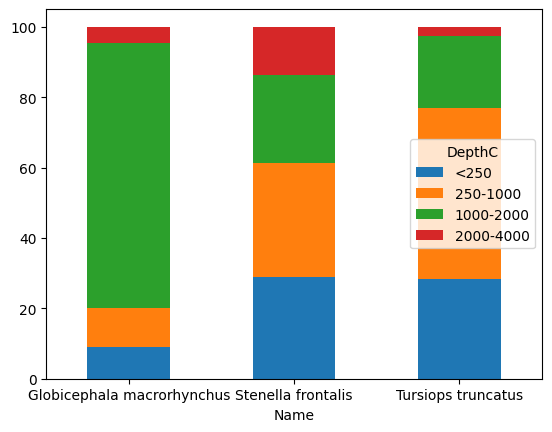

In [44]:
import plotly.express as px
from scipy.stats import chi2_contingency
import statsmodels.api as sm

df["DepthQ"]=pd.qcut(df.Depth,4,labels=["D1","D2",
   "D3","D4"])

df['DepthC'] = pd.cut(x=df['Depth'], bins=[-100,250,
                                          1000,2000,4000],labels=['<250','250-1000','1000-2000','2000-4000'])

df["N"] = 1
df_depth1 = df.groupby(['DepthC', 'Name'])['N'].sum().reset_index()
df_depth2 = df.groupby(['Name'])['N'].sum().reset_index()
df_depth = pd.merge(df_depth1, df_depth2, on='Name', how='outer')
df_depth['Percentage'] = df_depth['N_x']/df_depth['N_y']*100
print(df_depth)

fig = px.bar(df_depth, x='Name', y='Percentage', color="DepthC",template='plotly_white',labels={"N": "# sightings","Name" : "Species"})
fig.show()

# Creating barplot
obs_freq = pd.crosstab(df['Name'], df['DepthC'], normalize='index')\
    .round(4)*100
pl = obs_freq.plot(kind="bar", stacked=True, rot=0)

#Independence test of Depth

obs = pd.crosstab(df['Name'], df['DepthC'],margins = False)
print(obs)

print("\nTest chi2 version 1")
chi2, p, dof, ex = chi2_contingency(obs, correction=False)
print (f"chi2 = {chi2}, p= {p}, dof= {dof}")
print (ex)

print("\nTest chi2 version 2")
#https://www.statsmodels.org/stable/contingency_tables.html

print("\nOriginal data")
table = sm.stats.Table(obs)
print(table.table_orig)

print("\nExpected values")
print(table.fittedvalues)
print("\nResidual values")
print(table.resid_pearson)

rslt = table.test_nominal_association()
print("p value")
print(rslt.pvalue)
print("\nContributions")
print(table.chi2_contribs)



# Distance from shore

Shore                       <1km  1-5km  5-10km  >10km
Name                                                  
Globicephala macrorhynchus     8     19      55     28
Stenella frontalis            40     12      43     96
Tursiops truncatus            30     36      32     50
     Shore                        Name  N_x  N_y  Percentage
0     <1km  Globicephala macrorhynchus    8  110    7.272727
1    1-5km  Globicephala macrorhynchus   19  110   17.272727
2   5-10km  Globicephala macrorhynchus   55  110   50.000000
3    >10km  Globicephala macrorhynchus   28  110   25.454545
4     <1km          Stenella frontalis   40  191   20.942408
5    1-5km          Stenella frontalis   12  191    6.282723
6   5-10km          Stenella frontalis   43  191   22.513089
7    >10km          Stenella frontalis   96  191   50.261780
8     <1km          Tursiops truncatus   30  148   20.270270
9    1-5km          Tursiops truncatus   36  148   24.324324
10  5-10km          Tursiops truncatus   32  148   21.


Test chi2 version 1
chi2 = 62.108574616713796, p= 1.6767144696651208e-11, dof= 6
[[19.1091314  16.4142539  31.84855234 42.62806236]
 [33.18040089 28.50111359 55.30066815 74.01781737]
 [25.71046771 22.08463252 42.85077951 57.35412027]]

Test chi2 version 2

Original data
Shore                       <1km  1-5km  5-10km  >10km
Name                                                  
Globicephala macrorhynchus     8     19      55     28
Stenella frontalis            40     12      43     96
Tursiops truncatus            30     36      32     50

Expected values
Shore                            <1km      1-5km     5-10km      >10km
Name                                                                  
Globicephala macrorhynchus  19.109131  16.414254  31.848552  42.628062
Stenella frontalis          33.180401  28.501114  55.300668  74.017817
Tursiops truncatus          25.710468  22.084633  42.850780  57.354120

Residual values
Shore                           <1km     1-5km    5-10km     >10

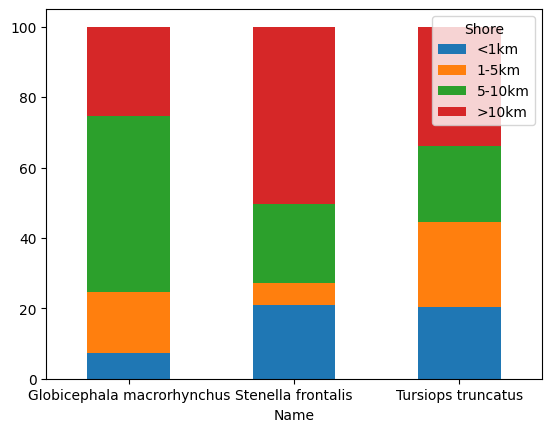

In [45]:
import plotly.express as px
from scipy.stats import chi2_contingency
import statsmodels.api as sm

df['Shore'] = pd.cut(x=df['Shore distance'], bins=[-100,1000,
                                          5000,10000,900000],labels=['<1km','1-5km','5-10km','>10km'])
obs_shore = pd.crosstab(df['Name'], df['Shore'],margins = False)
print(obs_shore)

df["N"] = 1
df_shore1 = df.groupby(['Shore', 'Name'])['N'].sum().reset_index()
df_shore2 = df.groupby(['Name'])['N'].sum().reset_index()
df_shore = pd.merge(df_shore1, df_shore2, on='Name', how='outer')
df_shore['Percentage'] = df_shore['N_x']/df_shore['N_y']*100
print(df_shore)

# Creating barplot
obs_freq = pd.crosstab(df['Name'], df['Shore'], normalize='index')\
    .round(4)*100
pl = obs_freq.plot(kind="bar", stacked=True, rot=0)

fig = px.bar(df_shore, x='Name', y='Percentage', color="Shore",template='plotly_white',labels={"N": "# sightings","Name" : "Species"})
fig.show()

#Independence test of Shore Distance
print("\nTest chi2 version 1")
chi2, p, dof, ex = chi2_contingency(obs_shore, correction=False)
print (f"chi2 = {chi2}, p= {p}, dof= {dof}")
print (ex)

print("\nTest chi2 version 2")
#https://www.statsmodels.org/stable/contingency_tables.html

print("\nOriginal data")
table = sm.stats.Table(obs_shore)
print(table.table_orig)

print("\nExpected values")
print(table.fittedvalues)
print("\nResidual values")
print(table.resid_pearson)

rslt = table.test_nominal_association()
print("p value")
print(rslt.pvalue)
print("\nContributions")
print(table.chi2_contribs)